# Mobility Friction Mapping: Seattle Accessibility Analysis

## Setup and Imports

In [18]:
! pip install pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Data Loading and Exploration

In [5]:
# Load GeoJSON data
with open('attributes-seattle.json', 'r') as f:
    data = json.load(f)

# Extract features
records = []
for feature in data['features']:
    record = {
        'longitude': feature['geometry']['coordinates'][0],
        'latitude': feature['geometry']['coordinates'][1],
        'attribute_id': feature['properties']['attribute_id'],
        'label_type': feature['properties']['label_type'],
        'neighborhood': feature['properties']['neighborhood'],
        'severity': feature['properties']['severity'],
        'is_temporary': feature['properties']['is_temporary']
    }
    records.append(record)

df = pd.DataFrame(records)

print(f"Total observations: {len(df):,}")
print(f"Neighborhoods: {df['neighborhood'].nunique()}")
print(f"Barrier types: {df['label_type'].nunique()}")
df.head()

Total observations: 81,973
Neighborhoods: 50
Barrier types: 7


,longitude,latitude,attribute_id,label_type,neighborhood,severity,is_temporary
0,-122.298981,47.594616,52096165,SurfaceProblem,Atlantic,4.0,False
1,-122.301071,47.593357,52096166,SurfaceProblem,Atlantic,3.0,False
2,-122.301079,47.596844,52096167,SurfaceProblem,Atlantic,4.0,False
3,-122.301071,47.596500,52096168,SurfaceProblem,Atlantic,4.0,False
4,-122.306274,47.599930,52096365,NoCurbRamp,Atlantic,4.0,False


In [6]:
# Data summary
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 81973 entries, 0 to 81972
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   longitude     81973 non-null  float64
 1   latitude      81973 non-null  float64
 2   attribute_id  81973 non-null  int64  
 3   label_type    81973 non-null  str    
 4   neighborhood  81973 non-null  str    
 5   severity      79722 non-null  float64
 6   is_temporary  81973 non-null  bool   
dtypes: bool(1), float64(3), int64(1), str(2)
memory usage: 3.8 MB


In [7]:
# Basic statistics
df.describe()

,longitude,latitude,attribute_id,severity
count,81973.000000,81973.000000,8.197300e+04,79722.000000
mean,-122.332226,47.631158,5.207014e+07,2.807531
std,0.037651,0.051508,1.984812e+05,1.312686
min,-122.418427,47.495449,4.824752e+07,1.000000
25%,-122.360863,47.590382,5.207874e+07,2.000000
50%,-122.327072,47.638321,5.210622e+07,3.000000
75%,-122.302139,47.672363,5.214016e+07,4.000000
max,-122.238960,47.734531,5.216889e+07,5.000000


## 2. Data Analysis

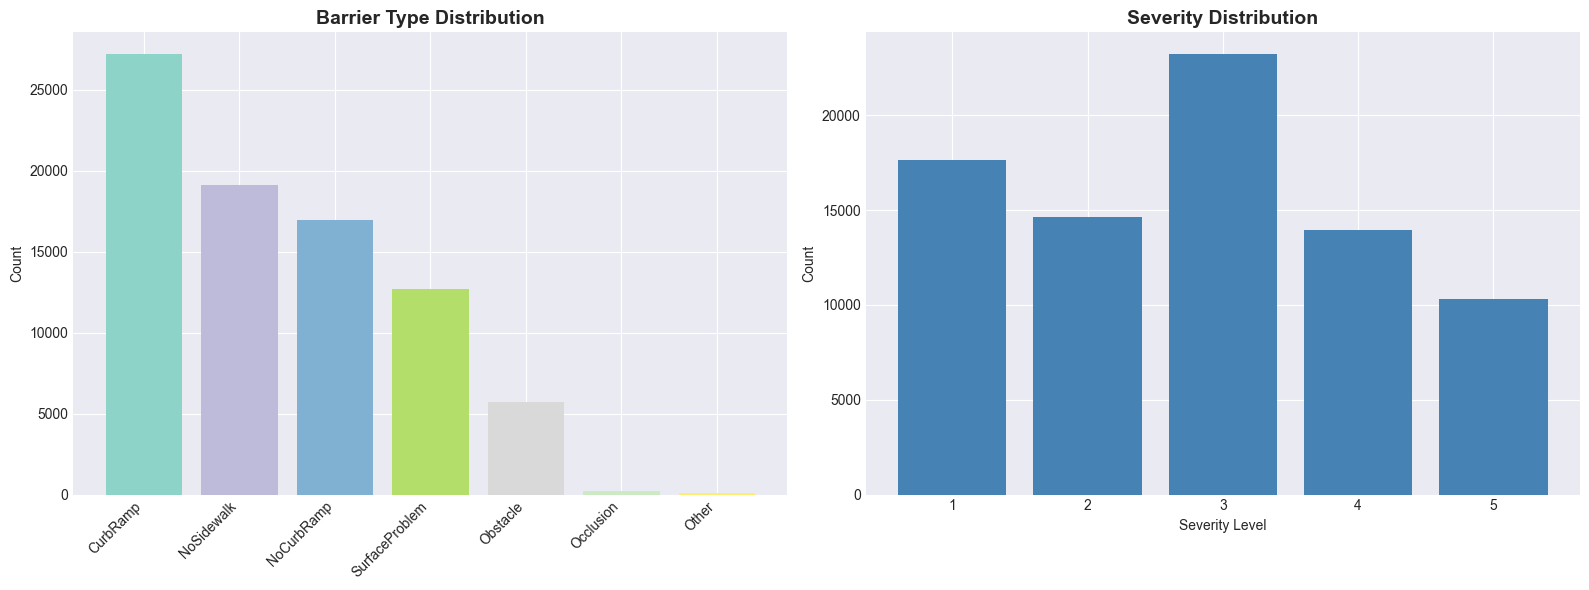

In [8]:
# Barrier type distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

barrier_counts = df['label_type'].value_counts()
axes[0].bar(range(len(barrier_counts)), barrier_counts.values, color=plt.cm.Set3(np.linspace(0, 1, len(barrier_counts))))
axes[0].set_xticks(range(len(barrier_counts)))
axes[0].set_xticklabels(barrier_counts.index, rotation=45, ha='right')
axes[0].set_title('Barrier Type Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')

severity_counts = df['severity'].value_counts().sort_index()
axes[1].bar(severity_counts.index, severity_counts.values, color='steelblue')
axes[1].set_title('Severity Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Severity Level')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

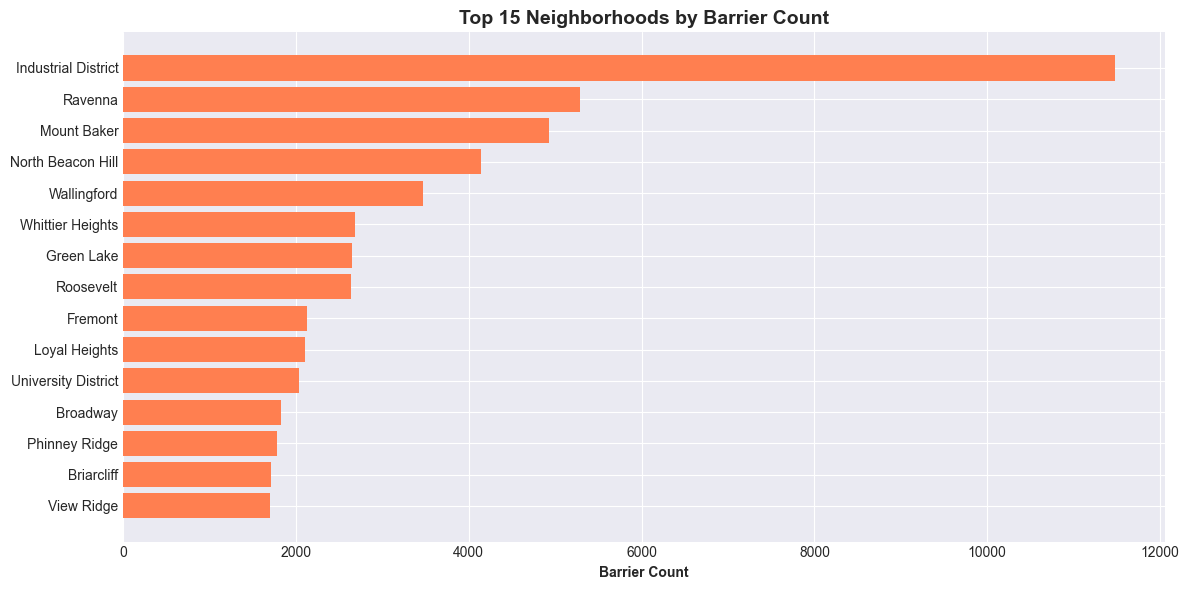

In [9]:
# Top neighborhoods
neighborhood_counts = df['neighborhood'].value_counts().head(15)
plt.figure(figsize=(12, 6))
plt.barh(range(len(neighborhood_counts)), neighborhood_counts.values, color='coral')
plt.yticks(range(len(neighborhood_counts)), neighborhood_counts.index)
plt.xlabel('Barrier Count', fontweight='bold')
plt.title('Top 15 Neighborhoods by Barrier Count', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Features

In [10]:
# Create spatial grid
df['lat_grid'] = (df['latitude'] * 100).astype(int) / 100
df['lon_grid'] = (df['longitude'] * 100).astype(int) / 100
df['grid_cell'] = df['lat_grid'].astype(str) + '_' + df['lon_grid'].astype(str)

# Barrier density per grid cell
grid_density = df.groupby('grid_cell').size().reset_index(name='barrier_density')
df = df.merge(grid_density, on='grid_cell', how='left')

# Neighborhood-level features
neighborhood_severity = df.groupby('neighborhood')['severity'].agg(['mean', 'max', 'std']).reset_index()
neighborhood_severity.columns = ['neighborhood', 'neighborhood_avg_severity', 
                                  'neighborhood_max_severity', 'neighborhood_severity_std']
df = df.merge(neighborhood_severity, on='neighborhood', how='left')

# Permanence ratio
permanence_ratio = df.groupby('neighborhood')['is_temporary'].apply(
    lambda x: (1 - x.sum() / len(x)) * 100
).reset_index(name='permanent_barrier_pct')
df = df.merge(permanence_ratio, on='neighborhood', how='left')

# Encode categoricals
le_barrier = LabelEncoder()
df['barrier_type_encoded'] = le_barrier.fit_transform(df['label_type'])

le_neighborhood = LabelEncoder()
df['neighborhood_encoded'] = le_neighborhood.fit_transform(df['neighborhood'])

df['is_permanent'] = (~df['is_temporary']).astype(int)

print("Feature engineering complete!")
df[['barrier_density', 'neighborhood_avg_severity', 'permanent_barrier_pct']].describe()

Feature engineering complete!


,barrier_density,neighborhood_avg_severity,permanent_barrier_pct
count,81973.000000,81973.000000,81973.000000
mean,488.213570,2.807295,99.059446
std,238.790137,0.448352,1.051114
min,2.000000,1.603865,92.328042
25%,320.000000,2.560000,98.966408
50%,496.000000,2.771202,99.350181
75%,651.000000,3.290514,99.602423
max,1173.000000,3.430206,100.000000


## 4. Severity Prediction

In [11]:
# Prepare ML features
df_ml = df.dropna(subset=['severity']).copy()

feature_cols = ['longitude', 'latitude', 'barrier_type_encoded', 
                'is_permanent', 'barrier_density', 
                'neighborhood_avg_severity', 'permanent_barrier_pct']

X = df_ml[feature_cols].fillna(df_ml[feature_cols].mean())
y = df_ml['severity']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,}")
print(f"Test set: {len(X_test):,}")

Training set: 63,777
Test set: 15,945


In [12]:
# Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15, 
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.6886

Classification Report:
              precision    recall  f1-score   support

         1.0       0.69      0.81      0.74      3529
         2.0       0.60      0.52      0.55      2923
         3.0       0.67      0.75      0.71      4642
         4.0       0.78      0.59      0.68      2792
         5.0       0.76      0.72      0.74      2059

    accuracy                           0.69     15945
   macro avg       0.70      0.68      0.68     15945
weighted avg       0.69      0.69      0.69     15945



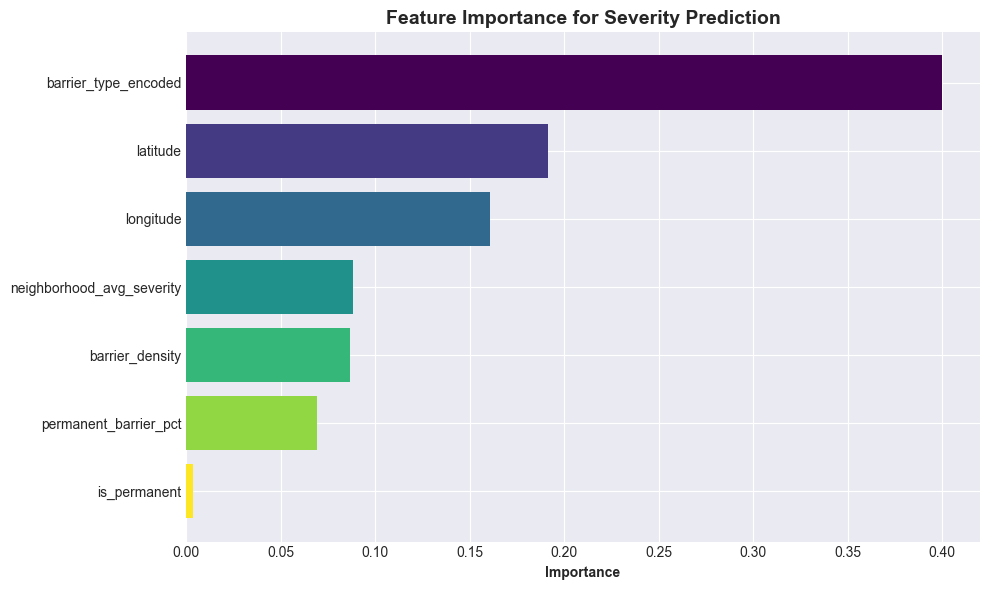

                     feature  importance
2       barrier_type_encoded    0.400006
1                   latitude    0.191423
0                  longitude    0.161021
5  neighborhood_avg_severity    0.088083
4            barrier_density    0.086692
6      permanent_barrier_pct    0.069092
3               is_permanent    0.003682


In [13]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'], 
         color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance))))
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance', fontweight='bold')
plt.title('Feature Importance for Severity Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(feature_importance)

## 5. Spatial Clustering: Hotspot Detection

In [14]:
# Focus on severe permanent barriers
severe_barriers = df[(df['severity'] >= 3) & (df['is_permanent'] == 1)].copy()
coords = severe_barriers[['latitude', 'longitude']].values

# DBSCAN clustering
dbscan = DBSCAN(eps=0.001, min_samples=5)
severe_barriers['cluster'] = dbscan.fit_predict(coords)

n_clusters = len(set(severe_barriers['cluster'])) - (1 if -1 in severe_barriers['cluster'] else 0)
n_noise = list(severe_barriers['cluster']).count(-1)

print(f"Hotspot clusters: {n_clusters}")
print(f"Isolated barriers: {n_noise}")

Hotspot clusters: 698
Isolated barriers: 1493


In [15]:
# Analyze clusters
cluster_summary = severe_barriers[severe_barriers['cluster'] != -1].groupby('cluster').agg({
    'attribute_id': 'count',
    'severity': 'mean',
    'latitude': 'mean',
    'longitude': 'mean',
    'neighborhood': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()

cluster_summary.columns = ['cluster', 'barrier_count', 'avg_severity', 
                           'center_lat', 'center_lon', 'primary_neighborhood']
cluster_summary = cluster_summary.sort_values('barrier_count', ascending=False)

print("\nTop 10 Accessibility Hotspots:")
cluster_summary.head(10)


Top 10 Accessibility Hotspots:


,cluster,barrier_count,avg_severity,center_lat,center_lon,primary_neighborhood
3,3,5743,3.509316,47.593846,-122.295293,North Beacon Hill
29,29,3995,4.017272,47.686688,-122.301733,Ravenna
150,150,1991,3.883978,47.573705,-122.331803,Industrial District
7,7,1976,3.829960,47.663055,-122.350213,Fremont
274,274,1944,3.397634,47.637168,-122.359222,East Queen Anne
14,14,1843,4.060770,47.688615,-122.376209,Whittier Heights
2,2,1409,3.423705,47.604668,-122.315804,Minor
43,43,933,3.320472,47.726742,-122.302113,Ravenna
148,148,874,3.718535,47.557568,-122.334153,Industrial District
462,462,783,4.056194,47.668844,-122.328172,Wallingford


## 6. Mobility Friction Index (MFI) Calculation

In [16]:
# Calculate MFI components by neighborhood
mfi_data = df.groupby('neighborhood').agg({
    'attribute_id': 'count',
    'severity': 'mean',
    'is_permanent': 'sum',
}).reset_index()

mfi_data.columns = ['neighborhood', 'total_barriers', 'avg_severity', 'permanent_count']
mfi_data['permanent_ratio'] = mfi_data['permanent_count'] / mfi_data['total_barriers']

# Add cluster counts
cluster_by_neighborhood = severe_barriers[severe_barriers['cluster'] != -1].groupby(
    'neighborhood'
)['cluster'].nunique().reset_index(name='hotspot_clusters')
mfi_data = mfi_data.merge(cluster_by_neighborhood, on='neighborhood', how='left')
mfi_data['hotspot_clusters'] = mfi_data['hotspot_clusters'].fillna(0)

# Normalize components
scaler = MinMaxScaler()
mfi_data['norm_barriers'] = scaler.fit_transform(mfi_data[['total_barriers']])
mfi_data['norm_severity'] = scaler.fit_transform(mfi_data[['avg_severity']])
mfi_data['norm_permanent'] = scaler.fit_transform(mfi_data[['permanent_ratio']])
mfi_data['norm_hotspots'] = scaler.fit_transform(mfi_data[['hotspot_clusters']])

# Calculate MFI
mfi_data['MFI'] = (
    0.30 * mfi_data['norm_barriers'] +
    0.25 * mfi_data['norm_severity'] +
    0.25 * mfi_data['norm_permanent'] +
    0.20 * mfi_data['norm_hotspots']
) * 100

mfi_data['MFI_category'] = pd.cut(
    mfi_data['MFI'], 
    bins=[0, 25, 50, 75, 100],
    labels=['Low Friction', 'Moderate Friction', 'High Friction', 'Severe Friction']
)

mfi_data = mfi_data.sort_values('MFI', ascending=False)

print("MFI Calculation Complete!\n")
print("Top 10 Neighborhoods by Mobility Friction:")
mfi_data.head(10)

MFI Calculation Complete!

Top 10 Neighborhoods by Mobility Friction:


,neighborhood,total_barriers,avg_severity,permanent_count,permanent_ratio,hotspot_clusters,norm_barriers,norm_severity,norm_permanent,norm_hotspots,MFI,MFI_category
14,Industrial District,11481,3.290514,11425,0.995122,169,1.000000,0.923513,0.936423,1.000000,96.498389,Severe Friction
34,Ravenna,5282,3.417517,5261,0.996024,30,0.454025,0.993052,0.948178,0.172619,65.603884,High Friction
47,Whittier Heights,2684,3.430206,2673,0.995902,33,0.225207,1.000000,0.946580,0.190476,59.230233,High Friction
27,Mount Baker,4924,2.760938,4879,0.990861,61,0.422494,0.633547,0.880879,0.357143,57.678337,High Friction
43,Wallingford,3470,3.252496,3452,0.994813,24,0.294434,0.902696,0.932386,0.136905,57.448154,High Friction
42,View Ridge,1699,3.419938,1696,0.998234,25,0.138453,0.994378,0.976984,0.142857,56.294798,High Friction
35,Roosevelt,2634,3.075261,2615,0.992787,24,0.220803,0.805652,0.905978,0.136905,52.152935,High Friction
15,Interbay,637,3.352349,634,0.995290,21,0.044918,0.957370,0.938613,0.119048,51.128072,High Friction
28,North Beacon Hill,4147,2.644444,4101,0.988908,32,0.354060,0.569762,0.855417,0.184524,49.941754,Moderate Friction
36,Sand Point,188,3.303371,188,1.000000,7,0.005373,0.930552,1.000000,0.035714,49.139270,Moderate Friction


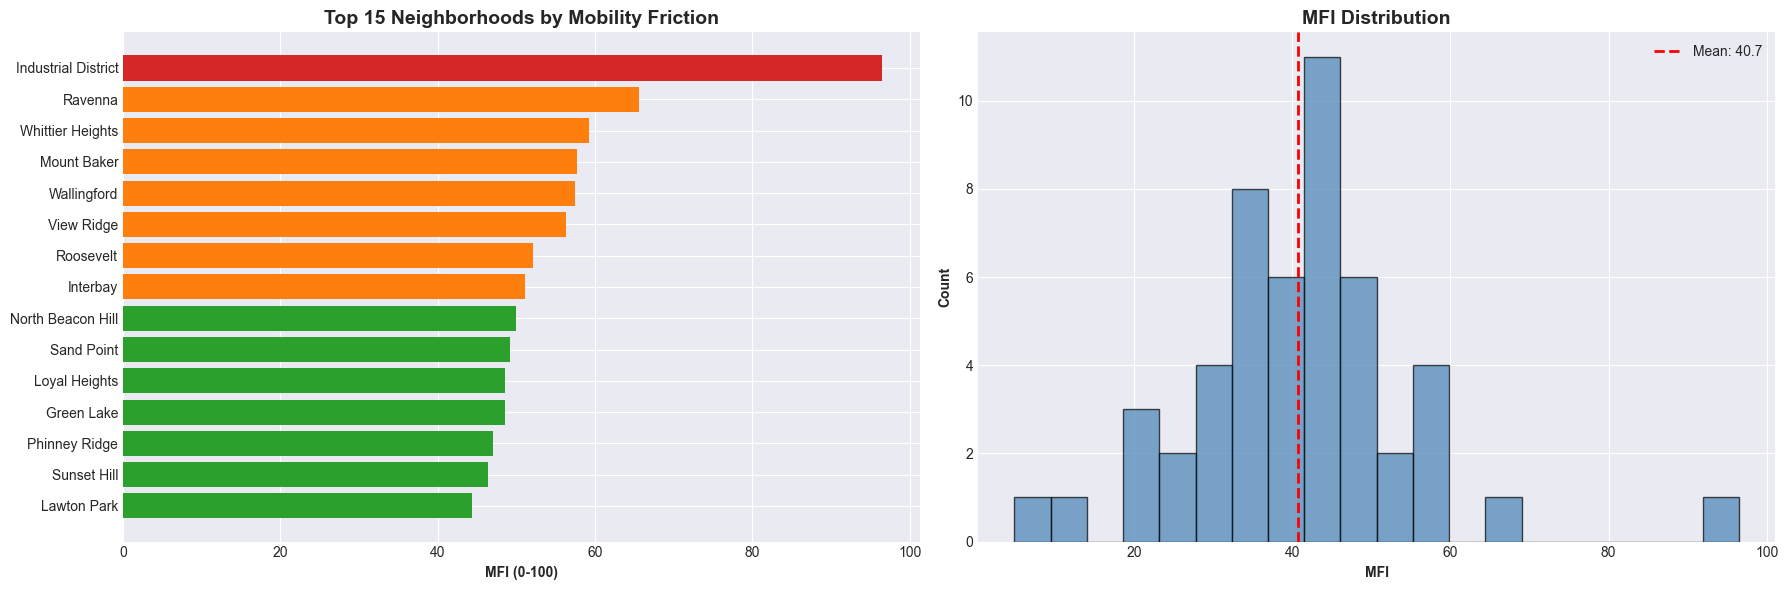

In [17]:
# Visualize MFI
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 15 by MFI
top_mfi = mfi_data.nlargest(15, 'MFI')
colors = ['#d62728' if x >= 75 else '#ff7f0e' if x >= 50 else '#2ca02c' for x in top_mfi['MFI']]
axes[0].barh(range(len(top_mfi)), top_mfi['MFI'], color=colors)
axes[0].set_yticks(range(len(top_mfi)))
axes[0].set_yticklabels(top_mfi['neighborhood'])
axes[0].set_xlabel('MFI (0-100)', fontweight='bold')
axes[0].set_title('Top 15 Neighborhoods by Mobility Friction', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# MFI distribution
axes[1].hist(mfi_data['MFI'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(mfi_data['MFI'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mfi_data["MFI"].mean():.1f}')
axes[1].set_xlabel('MFI', fontweight='bold')
axes[1].set_ylabel('Count', fontweight='bold')
axes[1].set_title('MFI Distribution', fontsize=14, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Priority Intervention Areas

In [ ]:
# Identify priority areas
priority = mfi_data[
    (mfi_data['MFI'] >= 60) & 
    (mfi_data['permanent_ratio'] >= 0.8) & 
    (mfi_data['hotspot_clusters'] >= 2)
].copy()

if len(priority) == 0:
    priority = mfi_data.head(10)

print(f"Priority Intervention Areas: {len(priority)}\n")
priority[['neighborhood', 'total_barriers', 'avg_severity', 
          'permanent_ratio', 'hotspot_clusters', 'MFI']]

## 8. Geographic Visualization

In [ ]:
# Heatmap of barriers
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

ax.hexbin(df['longitude'], df['latitude'], gridsize=50, cmap='YlOrRd', mincnt=1)
ax.set_title('Seattle Accessibility Barrier Density Heatmap', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
plt.colorbar(ax.collections[0], ax=ax, label='Barrier Count')
plt.tight_layout()
plt.show()

## Conclusion

This analysis revealed:
1. **20× inequity** between highest (Industrial District: 96.5) and lowest (South Lake Union: 4.9) friction neighborhoods
2. **698 accessibility hotspots** requiring intervention
3. **69% ML accuracy** in predicting barrier severity
4. **99% permanent barriers** indicating systemic design failures
5. **2 priority areas** needing immediate action (Industrial District, Ravenna)

The Mobility Friction Index provides a data-driven framework for prioritizing accessibility improvements across Seattle.